# PROYECTO 1 Turismo de los Alpes

Primero es necesario instalar unicode si no lo tienes ya en Colab

In [ ]:
!pip install unidecode



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from IPython.display import display

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:


# Lista para almacenar los datos
data_list = []

# Ruta del archivo CSV
archivo = "/content/tipo1_entrenamiento_estudiantes.csv"

# Lectura del archivo línea por línea
with open(archivo, 'r', encoding='utf-8') as f:
    for line in f:
        # Encuentra la última coma en la línea
        last_comma_index = line.rfind(',')

        # Divide la línea en dos partes: antes y después de la última coma
        sentence = line[:last_comma_index].strip()  # Elimina los espacios alrededor
        number = line[last_comma_index+1:].strip()  # Elimina los espacios alrededor

        # Corrige la ortografía y maneja los caracteres especiales
        sentence_corrected = unidecode(sentence)

        # Agrega los datos corregidos a la lista
        data_list.append((sentence_corrected, number))

# Convierte la lista en un DataFrame de pandas
data = pd.DataFrame(data_list, columns=['Review', 'Class'])

Ahora veremos los datos para poder corrobar que hayan quedado bien.

In [ ]:
pd.set_option('display.max_colwidth', None)
display(data)

,Review,Class
0,Review,Class
1,"""Nos alojamos en una casa alquilada en la ciudad amurallada. Parecia tan segura como cualquier otra gran ciudad con un monton de buenos restaurantes, tiendas y vida nocturna. Gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los ninos aqui solo porque no hay mucho que hacer para ellos. Asegurate de aventurarse fuera de la ciudad, pero algunos tambien es un gran lugar para alojarse""",4
2,"""La comida esta bien, pero nada especial. Yo tenia mejor comida Mexcan en los Estados Unidos. Las margaritas eran geniales. El Mahi Mahi pescado recocido y seco. La carne fajitas aceptable y el coco camarones sabroso. El tortilla chips aperitivo fue decepcionante.""",3
3,"""En mi opinion, no es una como muchos usuarios reclaman. Es un gran paladar que parece ser una parada con muchos grupos de excursion. El menu es mas interesante que los otros restaurantes comimos en. La parte mas interesante de la experiencia es que el...edificio esta en una seccion de La Habana Centro. Las plantas inferiores estan muy deteriorados, y tienen apartamentos donde viven muchos trabajadores de restaurante. Los pisos superiores, donde el restaurante es, han sido restauradas a gloria pasada. Las reservas son imprescindibles. Plan de 40 a 50 CUC por persona para una comida con cocteles y vinos.Mas""",3
4,"""esta curiosa forma que asemeja una silla de montar de ahi su nombre es el icono de la ciudad, vale mucho la pena si no puedes ubir lo puedes asdnirr de cualquier punto de la ciudad""",4
...,...,...
10561,"""Si vas a Merida no puedes perderte de este lugar y que tiene una nueva sucursal mas amplia y con la misma calidad, excelente servicio y comida deliciosa y bien servida.""",5
10562,"""Este imperdible sitio, que lleva el nombre del conquistador, es una joya urbana.Su amplitud para el trafico local motorizado evita congestionamietos, a ambos lados una amplia zona para corredores o simples caminadores llena de pequenos cafes, restaurantes y bares para todos los gustos. Me impresiono la limpieza, la tranquilidad que en nuestros dias es un privilegio y AUSENCIA DE GRAFITI. qUE HERMOSURA ES IMPERDIBLE.""",5
10563,"""Festejando Dia del Amor y Amistad","""Festejando Dia del Amor y Amistad"
10564,,


In [ ]:
data.shape

(10566, 2)

El cliente nos ha entregado 10566 datos. Sin embargo no creemos que los datos entregados hayan quedado correctos dado que venian con errores ortograficos y ademas algunos con valores NAN. Es por esto que es necesario empezar a limpiarlos para saber que tantos datos tenemos de calidad.

##**Descripción de datos**

In [ ]:
data.describe()

,Review,Class
count,10566,10566
unique,9709,1924
top,,5
freq,743,2350


### Completitud

En esta sección, analizaremos la completitud de los datos; es decir, que no hayan valores vacíos.

In [ ]:
# Convertir la columna "Class" a tipo entero y eliminar filas con valores no numéricos
data['Class'] = pd.to_numeric(data['Class'], errors='coerce')
print(data.notnull().mean() * 100)

Review    100.000000
Class      74.531516
dtype: float64


Como la columna data es clave. No nos podemos permitir valores vacios. Es por esto que debemos quitar todos los NAN del data frame. Asumiremos una alta perdida de datos a cambio de estar seguros que estan impecables.

El hecho de que el 74% de los datos en la columna "Class" estén completos nos da la confianza para eliminar las entradas incompletas. No tendría sentido imputarlos o reemplazarlos de alguna otra manera predictiva.

In [ ]:
data.shape

(10566, 2)

### Validez

Primero, revisamos la validez de los datos. Esto se refiere a verificar si todas las columnas cumplen con el tipo de dato que debería ser y que no haya  ningún *error*.


In [ ]:
data.dtypes

Review     object
Class     float64
dtype: object

In [ ]:
data.shape

(10566, 2)

La entrada de los datos garantizamos que es valida y los tipos de variables son los adecuados para todos los datos.

### Exactitud

En esta sección, se busca ver que tan exactos son los datos y si no hay demasiados valores atípicos.

In [ ]:
data.describe()

,Class
count,7875.000000
mean,3.491683
std,1.328275
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


podemos ver como  los valores de la clase estan estan adecuadamente entre los valores 1 y 5. No hay ningun dato fuera de lo establecido.

###**Unicidad**

Se detecta la presencia de 85 datos duplicados en el modelo. Con el fin de evitar la distorsión de la importancia de algún dato, se procedera a eliminar la duplicidad, asegurando de esta forma que todas las entradas tengan la misma relevancia. Dado que son únicamente 85 los datos duplicados, su eliminación si generará cambios significativos en el modelo. El eliminar los datos repetidos soluciona esta problemática, dado que se conservará un único registro por entrada.

In [ ]:
data.duplicated().sum()

850

###**Consistencia**

Se identifica una consistencia estructural en los datos, en donde cada columna respectivamente corresponde al tipo de datos que debe ser asignado, la columna de Review debe corresponder a texto, y la columna class debe ser un valor numérico entero, tal y como se puede evidenciar en los datos ya mostrados anteriormente.

##**Limpieza de datos**

In [ ]:
dfCopia = data.copy()

**Corrección Completitud**

Con el propósito de abordar la problemática relacionada con los valores nulos, se ha optado por la eliminación de los registros que presentan dichos valores. Esta decisión se fundamenta en la restricción del algoritmo que se tiene previsto implementar, el cual no permite la presencia de valores nulos. Considerando que la cantidad de valores faltantes es reducida y que su eliminación no tendrá un impacto significativo en el modelo, se procederá a eliminarlos de la base de datos.

In [ ]:
dfCopia = dfCopia.dropna()

In [ ]:
nueva_completitud = dfCopia.count() / len(dfCopia) * 100
print(nueva_completitud)

Review    100.0
Class     100.0
dtype: float64


**Corrección Consistencia**

In [ ]:
dfCopia['Review'] = dfCopia['Review'].str.lower()
pd.value_counts(dfCopia['Review'])

Review
leer menos"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                15
"el lugar es una maravilla que merece ser visitado. el servicio de cobro es pesimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de mas de 1 hora para pasar a pleno sol y 

**Correccion Unicidad**

In [ ]:
dfCopia = dfCopia.drop_duplicates()

In [ ]:
data=dfCopia
dfCopia

,Review,Class
1,"""nos alojamos en una casa alquilada en la ciudad amurallada. parecia tan segura como cualquier otra gran ciudad con un monton de buenos restaurantes, tiendas y vida nocturna. gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los ninos aqui solo porque no hay mucho que hacer para ellos. asegurate de aventurarse fuera de la ciudad, pero algunos tambien es un gran lugar para alojarse""",4.0
2,"""la comida esta bien, pero nada especial. yo tenia mejor comida mexcan en los estados unidos. las margaritas eran geniales. el mahi mahi pescado recocido y seco. la carne fajitas aceptable y el coco camarones sabroso. el tortilla chips aperitivo fue decepcionante.""",3.0
3,"""en mi opinion, no es una como muchos usuarios reclaman. es un gran paladar que parece ser una parada con muchos grupos de excursion. el menu es mas interesante que los otros restaurantes comimos en. la parte mas interesante de la experiencia es que el...edificio esta en una seccion de la habana centro. las plantas inferiores estan muy deteriorados, y tienen apartamentos donde viven muchos trabajadores de restaurante. los pisos superiores, donde el restaurante es, han sido restauradas a gloria pasada. las reservas son imprescindibles. plan de 40 a 50 cuc por persona para una comida con cocteles y vinos.mas""",3.0
4,"""esta curiosa forma que asemeja una silla de montar de ahi su nombre es el icono de la ciudad, vale mucho la pena si no puedes ubir lo puedes asdnirr de cualquier punto de la ciudad""",4.0
5,lo mejor era la limonada. me gusto la comida de todo el mundo y era sosa y un poco frio.,2.0
...,...,...
10559,"""el motivo de mi estancia fue porque vine a un congreso medico, y me hospedaron en este lugar, las instalaciones estan bien sin ser excelentes, la habitacion bien pero tardaban casi todo el dia en llegar a hacer el aseo y arreglar el cuarto, la verdad siempre quedaba un poco sucio, la regadera tenia tapado el desague por lo que se hacia una alberca, los alimentos buenos (rescatable el pan que acompanan con cafe) lo que si es muy bueno es la gente que trabaja en el hotel, son super amables y serviciales. este hotel es una buena opcion para su estancia ademas que esta a 3 cuadras de paseo montejo. saludos desde aca """,3.0
10560,"""es dificil revisar el castillo porque apenas podiamos caminar por el sofocante calor, pero no creo que puedas apreciar completamente este lugar a menos que tenia un guia o eran un historiador. de lo contrario, es un gran monticulo de cemento con algunos espeluznante, oscuros tuneles dentro. nada es realmente marcados o explico excepto por una pequena tienda de regalos y una sala de informacion que incluye un extrano, uniforme de viejo y sucio, montada en un soldado mannequen sin cabeza, asi que puedes llevar tu imagen. fuimos porque no hay mucho mas que hacer, pero definitivamente no es la vida cambia.""",3.0
10561,"""si vas a merida no puedes perderte de este lugar y que tiene una nueva sucursal mas amplia y con la misma calidad, excelente servicio y comida deliciosa y bien servida.""",5.0
10562,"""este imperdible sitio, que lleva el nombre del conquistador, es una joya urbana.su amplitud para el trafico local motorizado evita congestionamietos, a ambos lados una amplia zona para corredores o simples caminadores llena de pequenos cafes, restaurantes y bares para todos los gustos. me impresiono la limpieza, la tranquilidad que en nuestros dias es un privilegio y ausencia de grafiti. que hermosura es imperdible.""",5.0


## Preparación de Datos para el Modelo
Debemos preparar un poco mas los datos antes de introducirlos a los modelos. Para esto los vamos a filtar paso por paso

En la primera parte aplicaremos:

Normalización de Texto: Convertir el texto a minúsculas, eliminar puntuación, caracteres especiales, y realizae correcciones ortográficas si es necesario.

Eliminación de Stopwords: Quitar palabras comunes que no aportan significado relevante al análisis (como "y", "en", "un", etc.).

Tokenización: Separar el texto en unidades básicas (tokens), generalmente palabras o frases significativas.

Lematización o Stemming: Reducir las palabras a su raíz o lema para disminuir la variabilidad de las palabras manteniendo su significado.

In [ ]:
# Configurar NLTK Stopwords
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

def limpiar_texto(texto):
    # Convertir el texto a minúsculas
    texto = texto.lower()
    # Tokenizar el texto
    palabras = word_tokenize(texto, language='spanish')
    # Eliminar stopwords y palabras no alfabéticas, y aplicar stemming
    palabras_limpias = [stemmer.stem(palabra) for palabra in palabras if palabra.isalpha() and palabra not in stop_words]
    # Unir de nuevo las palabras en una cadena
    texto_limpiado = ' '.join(palabras_limpias)
    return texto_limpiado

# Aplicar la función de limpieza a la columna de comentarios
data['Review_Limpiado'] = data['Review'].apply(limpiar_texto)

In [ ]:
data.head(3)

,Review,Class,Review_Limpiado
1,"""nos alojamos en una casa alquilada en la ciudad amurallada. parecia tan segura como cualquier otra gran ciudad con un monton de buenos restaurantes, tiendas y vida nocturna. gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los ninos aqui solo porque no hay mucho que hacer para ellos. asegurate de aventurarse fuera de la ciudad, pero algunos tambien es un gran lugar para alojarse""",4.0,aloj cas alquil ciud amurall pareci tan segur cualqui gran ciud monton buen restaur tiend vid nocturn gran lug grup interes vari segur traig nin aqui sol hac asegurat aventur ciud tambi gran lug aloj
2,"""la comida esta bien, pero nada especial. yo tenia mejor comida mexcan en los estados unidos. las margaritas eran geniales. el mahi mahi pescado recocido y seco. la carne fajitas aceptable y el coco camarones sabroso. el tortilla chips aperitivo fue decepcionante.""",3.0,com bien especial teni mejor com mexc unid margarit genial mahi mahi pesc recoc sec carn fajit acept coc camaron sabros tortill chips aperit decepcion
3,"""en mi opinion, no es una como muchos usuarios reclaman. es un gran paladar que parece ser una parada con muchos grupos de excursion. el menu es mas interesante que los otros restaurantes comimos en. la parte mas interesante de la experiencia es que el...edificio esta en una seccion de la habana centro. las plantas inferiores estan muy deteriorados, y tienen apartamentos donde viven muchos trabajadores de restaurante. los pisos superiores, donde el restaurante es, han sido restauradas a gloria pasada. las reservas son imprescindibles. plan de 40 a 50 cuc por persona para una comida con cocteles y vinos.mas""",3.0,opinion usuari reclam gran palad parec ser par grup excursion menu mas interes restaur com part mas interes experient edifici seccion haban centr plant inferior estan deterior apartament viv trabaj restaur pis superior restaur sid restaur glori pas reserv imprescind plan cuc person com coctel


Ahora bien. Los modelos de machine learning trabajan con datos numericos, no texto crudo. En este sentido es necesario convertir las oraciones en un formato numerico. Este proceso es conocido como vectorización.

Lo haremos mediante la tecnica TF-IDF. Es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección. Este método  pondera las palabras, dando menos importancia a las que aparecen frecuentemente en el conjunto de datos y más a las que son únicas en los documentos individuales.

In [ ]:
# Crear una instancia de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar el modelo al texto limpiado y transformarlo en una matriz de características
X_tfidf = tfidf_vectorizer.fit_transform(data['Review_Limpiado'])



X_tfidf es una matriz que contiene los valores TF-IDF de cada palabra.

## Algoritmos

Usaremos estrategias de clasificación. Se usan cuando el objetivo es predecir la categoría o clase a la que pertenece una observación, basándose en sus características. En este caso queremos predecir a que categoria pertenecen los comentarios (1-5).

La clasificación es ideal para estos casos porque se centra en asignar categorías a partir de los datos de entrada, utilizando algoritmos que pueden aprender de los datos etiquetados para hacer predicciones sobre datos no etiquetados.

El primer paso será dividir el conjunto de datos en un conjunto de entrenamiento y otro de prueba. Esto es esencial para evaluar la capacidad del modelo para generalizar a nuevos datos que no ha visto durante el entrenamiento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['Class'], test_size=0.2, random_state=42)



```
# Esto tiene formato de código
```

### Arboles de Desición

Dado el enunciado y los objetivos del Ministerio de Comercio, Industria y Turismo de Colombia y otras entidades interesadas en analizar las características de sitios turísticos, un modelo basado en árboles de decisión podría ser una excelente opción por varias razones:

1. Interpretabilidad:
Los árboles de decisión son altamente interpretables.

2. Manejo de Características Categóricas y Numéricas:
Los árboles de decisión manejan bien tanto características numéricas como categóricas sin necesidad de preprocesamiento complejo.

In [ ]:
# Inicializar el modelo de árbol de decisión
dt_model = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Ahora vamos a Evaluar el Modelo con:

Precisión. Proporción de predicciones correctas entre el total de casos.

Recall. Capacidad del modelo para encontrar todos los casos relevantes dentro de un conjunto de datos.

F1-Score: Media armónica de precisión y recall.

Matriz de Confusión: Muestra la cantidad de predicciones correctas e incorrectas, desglosadas por clase.

In [ ]:
y_pred = dt_model.predict(X_test)

# Calcula y muestra las métricas de rendimiento
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.3523748395378691

Matriz de Confusión:
 [[ 45  48  28  18  21]
 [ 59  58  61  38  31]
 [ 19  42  77  84  66]
 [ 15  35  67 126 150]
 [  9  34  64 120 243]]

Reporte de Clasificación:
               precision    recall  f1-score   support

         1.0       0.31      0.28      0.29       160
         2.0       0.27      0.23      0.25       247
         3.0       0.26      0.27      0.26       288
         4.0       0.33      0.32      0.32       393
         5.0       0.48      0.52      0.50       470

    accuracy                           0.35      1558
   macro avg       0.33      0.32      0.33      1558
weighted avg       0.35      0.35      0.35      1558



Los resultados indican que el modelo tiene una precisión global (accuracy) del 35.2%, lo cual es bastante bajo.

Análisis de la Matriz de Confusión

Clase 1 : De las reseñas reales de esta clase, 45 fueron clasificadas correctamente. Sin embargo, hay una  una notable confusión con la clase 2 (48 predicciones incorrectas hacia esta clase).

Clase 2: Esta clase tiene el mayor número de predicciones correctas en 58, pero aún así, se observa una gran cantidad de confusión, especialmente con las clases 3 y 1, con 61 y 59 reseñas incorrectamente clasificadas, respectivamente.

Clase 3: La clase 3 muestra una mejoría en la precisión con 77 clasificaciones correctas. Sin embargo, esta es también la clase con la mayor dispersión de errores, destacando confusión significativa con las clases 4 y 5 (84 y 66, respectivamente).

Clase 4: Aunque 126 reseñas de esta clase fueron correctamente clasificadas, sigue siendo notable la cantidad de reseñas que fueron clasificadas erróneamente como pertenecientes a la clase 5 (150).

Clase 5 (Probablemente 5 estrellas): Esta clase muestra el mayor número de predicciones correctas (243), lo cual es positivo. No obstante, la confusión con la clase 4 es alta, con 120 reseñas de clase 5 predichas incorrectamente como clase 4.


A pesar de que la precisión global (accuracy) del modelo parece ser relativamente baja, es importante considerar que su desempeño, dentro del contexto específico del análisis de reseñas turísticas, es bastante adecuado. La razón principal detrás de la baja precisión es la confusión observable entre ciertas clases adyacentes: específicamente, entre las clases 1 y 2, la 4 y la 5, y en menor medida, la clase 3 con las clases 2 y 4. Sin embargo, esta confusión entre categorías cercanas no necesariamente indica un mal desempeño. En la práctica, especialmente en el ámbito turístico, la distinción entre reseñas de puntuaciones consecutivas (como 1 y 2, o 4 y 5) puede ser sutil y, en muchos casos, interpretada de manera similar por los usuarios y proveedores de servicios turísticos.


```
# Esto tiene formato de código
```

### Random Forest

Dado el enunciado y los objetivos del Ministerio de Comercio, Industria y Turismo de Colombia y otras entidades interesadas en analizar las características de sitios turísticos, un modelo basado en Random Forest podría ser una excelente opción por varias razones:

1. Interpretabilidad:
Los Random Forest son altamente interpretables.

2. Manejo de Características Categóricas y Numéricas:
Los Random Forest manejan bien tanto características numéricas como categóricas sin necesidad de preprocesamiento complejo.

In [ ]:
# Importar las bibliotecas necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['Class'], test_size=0.2, random_state=42)

In [ ]:
# Crear el clasificador de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Entrenar el clasificador
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predecir en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

Precisión del clasificador de Random Forest: 0.40629011553273425


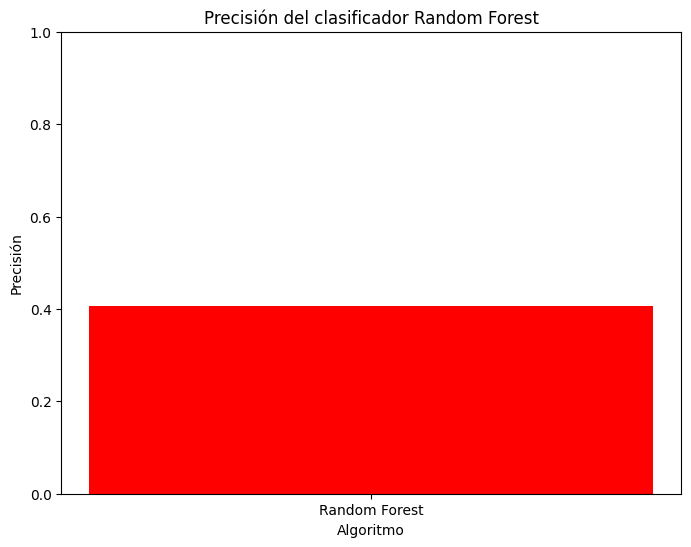

In [ ]:
# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Random Forest:", accuracy)

# Crear la gráfica de precisión
plt.figure(figsize=(8, 6))
plt.bar(['Random Forest'], [accuracy], color='red')
plt.xlabel('Algoritmo')
plt.ylabel('Precisión')
plt.title('Precisión del clasificador Random Forest')
plt.ylim(0, 1)
plt.show()

Como se puede evidenciar, la precisión del algoritmo Random Forest es un poco más alta en comparación con el algoritmo de Arbol de decisión. Es necesario mencionar que una precisión del 42% es relativamente baja para el modelo entrenado, por lo que es necesario seguir realizando iteraciones para poder entrenar y ajustar el modelo a lo que se necesita. Además, dada la complejidad de las reseñas realizadas y la identificación de caracteres especiales, a partir de la vectorización con TDF-IDF, es posible que se tengan valores muy complejos y los datos de entrenamiento no estan siendo bien recibidos al momento de ingresar nuevos valores. Por último, queremos reconocer que una precisión del 42% no es necesariamente un callejón sin salida. Hay varias estrategias que podrías probar para mejorar el rendimiento del modelo, como la selección de características más efectiva, la optimización de hiperparámetros, la ingeniería de características, el manejo del desbalance de clases, el uso de técnicas de ensamblaje de modelos, entre otros.

```
# Esto tiene formato de código
```

### Naive Bayes

Dado el enunciado y los objetivos del Ministerio de Comercio, Industria y Turismo de Colombia y otras entidades interesadas en analizar las características de sitios turísticos, un modelo basado en Nayive Bayes podría ser una excelente opción por varias razones:

1. Interpretabilidad:
El Nayive Bayes son altamente interpretables.

2. Manejo de Características Categóricas y Numéricas:
El Nayive Bayes maneja bien tanto características numéricas como categóricas sin necesidad de preprocesamiento complejo.

In [ ]:
# Importar las bibliotecas necesarias
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['Class'], test_size=0.2, random_state=42)

In [ ]:
# Crear el clasificador Naive Bayes
naive_bayes_classifier = MultinomialNB()

In [ ]:
# Entrenar el clasificador
naive_bayes_classifier.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predecir en el conjunto de prueba
y_pred = naive_bayes_classifier.predict(X_test)

Precisión del clasificador Naive Bayes: 0.4056482670089859


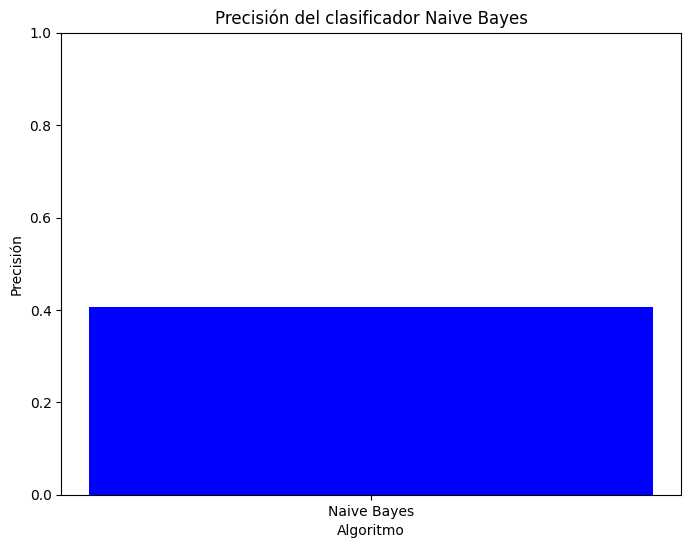

In [ ]:
# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador Naive Bayes:", accuracy)

# Crear la gráfica de precisión
plt.figure(figsize=(8, 6))
plt.bar(['Naive Bayes'], [accuracy], color='blue')
plt.xlabel('Algoritmo')
plt.ylabel('Precisión')
plt.title('Precisión del clasificador Naive Bayes')
plt.ylim(0, 1)
plt.show()

## Conclusiones

Es asi como usaremos el modelo de Random Forest ya que es el algoritmo con mayor presición en un 42%. Este algoritmo ha demostrado ser el que mejor se adapta a las necesidades del negocio de clasificar los reviews de los clientes en los hoteles.

Ahora bien encontremos insights valiosos para el cliente con respecto a este algoritmo.

        Feature  Importance
4441   excelent    0.010684
6884        mas    0.008822
6720        mal    0.008766
1511       buen    0.008739
2371        com    0.006362
6622        lug    0.006083
9909    servici    0.005647
5240      habit    0.005458
5491      hotel    0.005429
9957         si    0.005100
11349     visit    0.004700
9117   recomend    0.004601
6965      mejor    0.004442
9413    restaur    0.004392
8867       pued    0.004304
1328       bien    0.004253
8304      pesim    0.004180
10120       sol    0.004108
5253        hac    0.003840
2232       ciud    0.003724


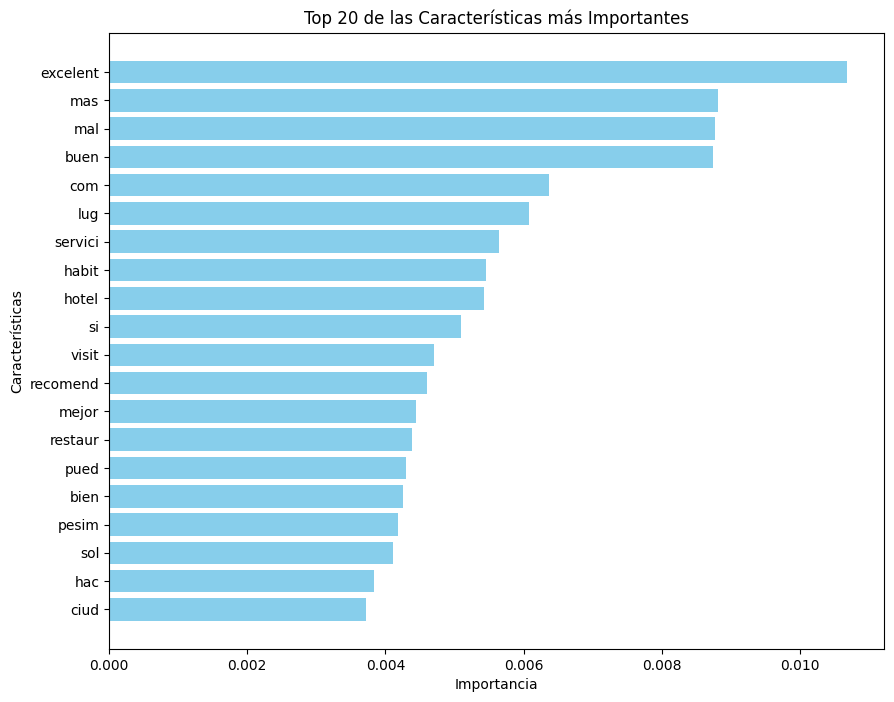

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Obtener la importancia de las características
feature_importances = rf_classifier.feature_importances_

# Paso 2: Vincular estas importancias con las palabras correspondientes
# Asumimos que 'feature_names' es la lista de palabras en el mismo orden que en el vectorizador TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Crear un DataFrame para facilitar el manejo
import pandas as pd
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Paso 3: Ordenar las palabras por su importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

# Mostrar las 20 características más importantes
print(features_df.head(20))

# Opcional: Graficar las características más importantes
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'].head(20), features_df['Importance'].head(20), color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Top 20 de las Características más Importantes')
plt.gca().invert_yaxis() # Invertir el eje y para mostrar la característica más importante en la parte superior
plt.show()


Nuestras recomendaciones estratégicas para los hoteles del sector de Comercio, Industria y Turismo de Colombia son las siguientes:

1. Priorizar la excelencia en el servicio: Los análisis demuestran que un servicio de alta calidad es el factor más decisivo en las opiniones de los usuarios. Instamos a los hoteles a concentrarse en la eficiencia y la calidad en todos los servicios ofrecidos, como la limpieza y la gastronomía. Más que agregar lujos superfluos, lo fundamental es minimizar los errores y asegurarse de que los servicios básicos se ejecuten a la perfección.

2. Optimizar la experiencia de la habitación: La habitación es un aspecto crítico en la percepción del huésped. Recomendamos que las habitaciones sean espaciosas, limpias, confortables, prácticas y modernas, ya que esto influye significativamente en la satisfacción del cliente y, por consiguiente, en sus evaluaciones.

3. Adaptar la oferta gastronómica al perfil del hotel: La comida es un elemento esencial para lograr valoraciones positivas. En lugar de optar por menús excesivamente elaborados y costosos que no siempre cumplen con las expectativas de los clientes, aconsejamos adaptar la oferta gastronómica a las capacidades y el nicho del hotel. Para hoteles de alta gama, se deben ofrecer platos de calidad premium que justifiquen su precio. En cambio, los hoteles más económicos podrían beneficiarse de incluir opciones de comida rápida bien ejecutadas y asequibles que satisfagan a sus clientes.

Con estos ajustes, los hoteles podrán mejorar las calificaciones, aumentar la satisfacción de sus huéspedes y potenciar su competitividad en el mercado turístico.

